In [3]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import os
import cv2
from tensorflow.keras import layers, models
from matplotlib import pyplot as plt
from matplotlib.pyplot import *
from pylab import *
from tensorflow.keras.preprocessing.image import img_to_array, array_to_img, load_img
from tensorflow.keras.utils import normalize

C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


### Loading and Preprocessing Data

In [4]:
def load_dataset(directory_path):
    images = []
    labels = []

    files = os.listdir(directory_path)

    for file in files:
        
        file_path = os.path.join(directory_path, file)
        image = cv2.imread(file_path)

        if image is not None:
            
            image = cv2.resize(image, (28, 28))  #resizing images to (28,28)

            label = file.split("_")[0]  

            images.append(image)
            labels.append(label)

            # Printing the dimensions of the image
            print(f"Image dimensions for {file}: {image.shape}")
        else:
            print(f"Failed to load image: {file_path}")

    # Convert lists to numpy arrays 
    images = np.array(images)
    labels = np.array(labels)
    images = np.flip(images, axis=-1) #bgr to rgb
    return images, labels

In [3]:
directory_path = 'Healthy\Healthydir'
images, labels = load_dataset(directory_path)

Image dimensions for image_001.png: (28, 28, 3)
Image dimensions for image_002.png: (28, 28, 3)
Image dimensions for image_003.png: (28, 28, 3)
Image dimensions for image_004.png: (28, 28, 3)
Image dimensions for image_005.png: (28, 28, 3)
Image dimensions for image_006.png: (28, 28, 3)
Image dimensions for image_007.png: (28, 28, 3)
Image dimensions for image_008.png: (28, 28, 3)
Image dimensions for image_009.png: (28, 28, 3)
Image dimensions for image_010.png: (28, 28, 3)
Image dimensions for image_011.png: (28, 28, 3)
Image dimensions for image_012.png: (28, 28, 3)
Image dimensions for image_013.png: (28, 28, 3)
Image dimensions for image_014.png: (28, 28, 3)
Image dimensions for image_015.png: (28, 28, 3)
Image dimensions for image_016.png: (28, 28, 3)
Image dimensions for image_017.png: (28, 28, 3)
Image dimensions for image_018.png: (28, 28, 3)
Image dimensions for image_019.png: (28, 28, 3)
Image dimensions for image_020.png: (28, 28, 3)
Image dimensions for image_021.png: (28,

Image dimensions for image_319.png: (28, 28, 3)
Image dimensions for image_320.png: (28, 28, 3)
Image dimensions for image_321.png: (28, 28, 3)
Image dimensions for image_322.png: (28, 28, 3)
Image dimensions for image_323.png: (28, 28, 3)
Image dimensions for image_324.png: (28, 28, 3)
Image dimensions for image_325.png: (28, 28, 3)
Image dimensions for image_326.png: (28, 28, 3)
Image dimensions for image_327.png: (28, 28, 3)
Image dimensions for image_328.png: (28, 28, 3)
Image dimensions for image_329.png: (28, 28, 3)
Image dimensions for image_330.png: (28, 28, 3)
Image dimensions for image_331.png: (28, 28, 3)
Image dimensions for image_332.png: (28, 28, 3)
Image dimensions for image_333.png: (28, 28, 3)
Image dimensions for image_334.png: (28, 28, 3)
Image dimensions for image_335.png: (28, 28, 3)
Image dimensions for image_336.png: (28, 28, 3)
Image dimensions for image_337.png: (28, 28, 3)
Image dimensions for image_338.png: (28, 28, 3)
Image dimensions for image_339.png: (28,

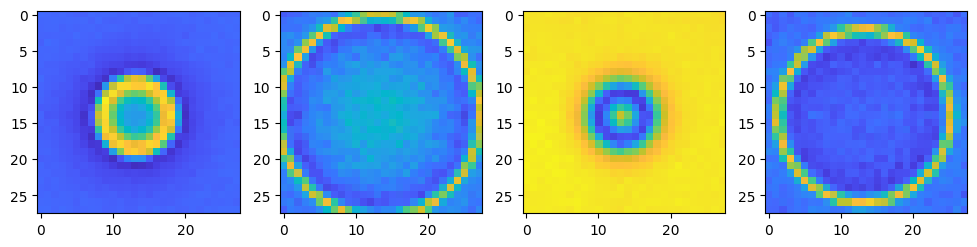

In [15]:
#Displaying any 4 random images
if len(images) >= 4:
    random_indices = np.random.choice(len(images), 4, replace=False)
    random_images = images[random_indices]

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for i in range(4):
        axes[i].imshow(random_images[i])
        
    plt.show()
else:
    print("Not enough images to display.")

In [16]:
images.shape

(365, 28, 28, 3)

In [17]:
#Normalizing so that pixel values lie between -1 and 1
images = (images - 127.5) / 127.5 
batch_size = 73
# Batching and shuffling
data = tf.data.Dataset.from_tensor_slices(images).shuffle(365).batch(batch_size)

### Generator Model

In [5]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout

In [6]:
def make_generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Change the output dimension to 28x28x3
    model.add(layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 3)

    return model

In [7]:
generator = make_generator_model()

generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

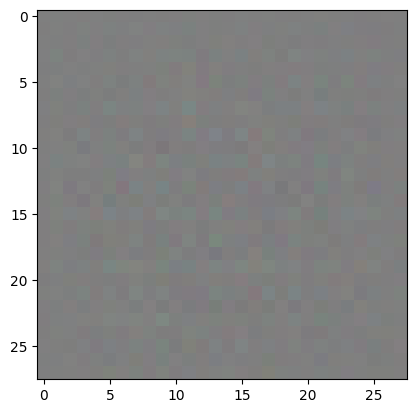

In [8]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

# Rescaling the pixel values from [-1, 1] to [0, 1]
generated_image_rescaled = (generated_image[0] + 1) / 2.0

# Display image
plt.imshow(generated_image_rescaled, interpolation='nearest')
plt.show()

### Discriminator Model

In [9]:
def make_discriminator_model():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same',
                            input_shape=[28, 28, 3]))  # Update input channels to 3
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    model.add(layers.Flatten())
    model.add(layers.Dense(1))

    return model

In [10]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        4864      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [11]:
#outputs negative values for fake images and positive for real
decision = discriminator(generated_image)
print (decision)

tf.Tensor([[-0.00114568]], shape=(1, 1), dtype=float32)


### Loss function and Optimizers

In [12]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

In [13]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

### Training

In [38]:
epochs = 1600
noise_dim = 100
num_examples_to_generate = 64

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [14]:
@tf.function
def train_step(images):
    noise = tf.random.normal([batch_size, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output)
      disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [15]:
def train(dataset, epochs):
  for epoch in range(epochs):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)
    
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                             epoch + 1,
                             seed)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # Generate after the final epoch
  display.clear_output(wait=True)
  generate_and_save_images(generator,
                           epochs,
                           seed)

In [16]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        # Rescale the pixel values to the range [0, 1]
        img = (predictions[i] + 1) * 0.5
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')

    # Save images for every 10 epochs
    if epoch % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        
    # Display the images for every epoch
    plt.show()

In [17]:
from IPython import display
from PIL import Image
import glob
import time

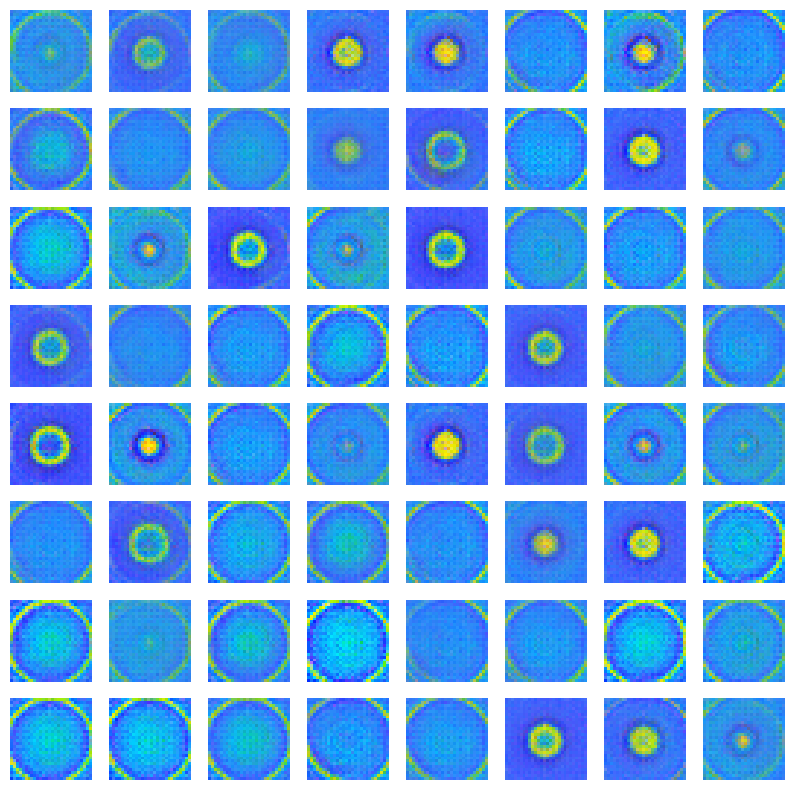

In [46]:
train(data, epochs)

In [57]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        fig = plt.figure(figsize=(1, 1))
        # Rescale the pixel values to the range [0, 1]
        img = (predictions[i] + 1) * 0.5
        
        img_np = img.numpy()
        
        # Resize the image to 256x256
        img = Image.fromarray((img_np * 255).astype(np.uint8))
        img = img.resize((256, 256), Image.ANTIALIAS)
        
        # Remove padding by cropping to the central 224x224 region
        left = (256 - 224) / 2
        top = (256 - 224) / 2
        right = (256 + 224) / 2
        bottom = (256 + 224) / 2
        img = img.crop((left, top, right, bottom))
    
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')

        # Save each image in a separate file
        plt.savefig('generated_image_{}.png'.format(i+1), bbox_inches='tight', pad_inches=0)
        plt.close()


In [50]:
train(data, 1)

C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\ipykernel_launcher.py:17: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  app.launch_new_instance()


Time for epoch 1 is 4.261580944061279 sec


In [53]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        # Rescale the pixel values to the range [0, 1]
        img = (predictions[i] + 1) * 0.5
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')

    # Save images for every 10 epochs
    if epoch % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch+1600))
        
    # Display the images for every epoch
    plt.show()

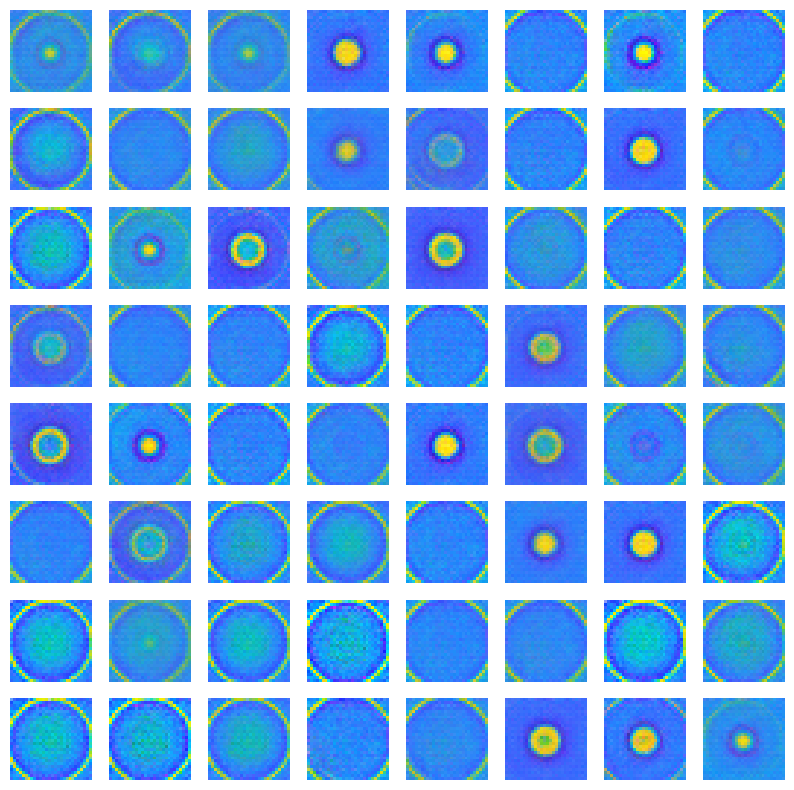

In [54]:
train(data, 800)

In [58]:
train(data, 1)

C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  del sys.path[0]


Time for epoch 1 is 4.271770477294922 sec


In [1]:
# DATA GENERATED DOES NOT CONTAIN IMAGES SIMILAR TO THE FIRST 60

In [18]:
directory_path = 'Healthy\Healthydir60'
images, labels = load_dataset(directory_path)

Image dimensions for image_001.png: (28, 28, 3)
Image dimensions for image_002.png: (28, 28, 3)
Image dimensions for image_003.png: (28, 28, 3)
Image dimensions for image_004.png: (28, 28, 3)
Image dimensions for image_005.png: (28, 28, 3)
Image dimensions for image_006.png: (28, 28, 3)
Image dimensions for image_007.png: (28, 28, 3)
Image dimensions for image_008.png: (28, 28, 3)
Image dimensions for image_009.png: (28, 28, 3)
Image dimensions for image_010.png: (28, 28, 3)
Image dimensions for image_011.png: (28, 28, 3)
Image dimensions for image_012.png: (28, 28, 3)
Image dimensions for image_013.png: (28, 28, 3)
Image dimensions for image_014.png: (28, 28, 3)
Image dimensions for image_015.png: (28, 28, 3)
Image dimensions for image_016.png: (28, 28, 3)
Image dimensions for image_017.png: (28, 28, 3)
Image dimensions for image_018.png: (28, 28, 3)
Image dimensions for image_019.png: (28, 28, 3)
Image dimensions for image_020.png: (28, 28, 3)
Image dimensions for image_021.png: (28,

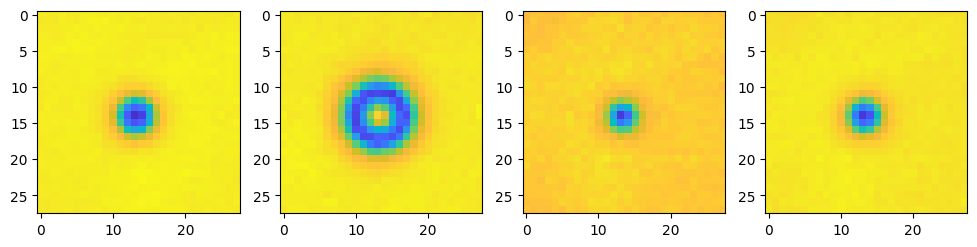

In [19]:
#Displaying any 4 random images
if len(images) >= 4:
    random_indices = np.random.choice(len(images), 4, replace=False)
    random_images = images[random_indices]

    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    for i in range(4):
        axes[i].imshow(random_images[i])
        
    plt.show()
else:
    print("Not enough images to display.")

In [20]:
images.shape

(60, 28, 28, 3)

In [21]:
#Normalizing so that pixel values lie between -1 and 1
images = (images - 127.5) / 127.5 
batch_size = 60
# Batching and shuffling
data60 = tf.data.Dataset.from_tensor_slices(images).shuffle(60).batch(batch_size)

In [25]:
epochs = 2400
noise_dim = 100
num_examples_to_generate = 8

seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [28]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(10, 10))

    for i in range(predictions.shape[0]):
        plt.subplot(8, 8, i+1)
        # Rescale the pixel values to the range [0, 1]
        img = (predictions[i] + 1) * 0.5
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')

    # Save images for every 10 epochs
    if epoch % 10 == 0:
        plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
        
    # Display the images for every epoch
    plt.show()

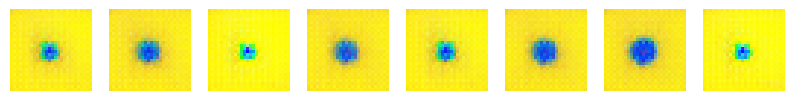

In [29]:
train(data60, epochs)

In [30]:
def generate_and_save_images(model, epoch, test_input):
    predictions = model(test_input, training=False)

    for i in range(predictions.shape[0]):
        fig = plt.figure(figsize=(1, 1))
        # Rescale the pixel values to the range [0, 1]
        img = (predictions[i] + 1) * 0.5
        
        img_np = img.numpy()
        
        # Resize the image to 256x256
        img = Image.fromarray((img_np * 255).astype(np.uint8))
        img = img.resize((256, 256), Image.ANTIALIAS)
        
        # Remove padding by cropping to the central 224x224 region
        left = (256 - 224) / 2
        top = (256 - 224) / 2
        right = (256 + 224) / 2
        bottom = (256 + 224) / 2
        img = img.crop((left, top, right, bottom))
    
        plt.imshow(img, interpolation='nearest')
        plt.axis('off')

        # Save each image in a separate file
        plt.savefig('generated_image_60{}.png'.format(i+1), bbox_inches='tight', pad_inches=0)
        plt.close()


In [31]:
train(data60, 1)

C:\Users\Manaswi\anaconda3\anaconda\envs\tgpu\lib\site-packages\ipykernel_launcher.py:13: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  del sys.path[0]


Time for epoch 1 is 1.396169662475586 sec
